In [40]:
import asl_dvs_gcp # Importing libraries for Google Cloud
import csv
import os
import numpy as np
import random
import tonic
import tonic.transforms as transforms

In [43]:
import torch
import torchvision
from torch.utils.data import DataLoader

sensor_size = (240,180,2)

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=100000)
                                     ])

trainset = asl_dvs_v2.ASLDVS(data_path="gs://asl-dataset-bucket-v4/asl_dataset_v3-003", train=True, transform=frame_transform) # reading data from Google Cloud Bucket
validset = asl_dvs_v2.ASLDVS(data_path="gs://asl-dataset-bucket-v4/asl_dataset_v3-003", train=False, transform=frame_transform)


batch_size = 25
trainloader = DataLoader(trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

In [44]:
print(len(trainset))
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

495
torch.Size([29, 25, 2, 180, 240])


In [45]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [46]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*57*42, 24),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [47]:
def forward_pass(net, data): # Forward propagation
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net
    
    for step in range(data.size(0)):  # data.size(0) = number of time steps
            spk_out, mem_out = net(data[step])
            spk_rec.append(spk_out)
            
    return torch.stack(spk_rec)
 

In [48]:
lr=0.0005 # setting up hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Epoch 0, Iteration 0 
Train Loss: 1.59
Accuracy: 4.00%

Epoch 0, Iteration 1 
Train Loss: 1.48
Accuracy: 8.00%

Epoch 0, Iteration 2 
Train Loss: 1.27
Accuracy: 0.00%

Epoch 0, Iteration 3 
Train Loss: 1.37
Accuracy: 8.00%

Epoch 0, Iteration 4 
Train Loss: 1.24
Accuracy: 28.00%

Epoch 0, Iteration 5 
Train Loss: 1.34
Accuracy: 8.00%

Epoch 0, Iteration 6 
Train Loss: 1.36
Accuracy: 12.00%

Epoch 0, Iteration 7 
Train Loss: 1.33
Accuracy: 8.00%

Epoch 0, Iteration 8 
Train Loss: 1.13
Accuracy: 12.00%

Epoch 0, Iteration 9 
Train Loss: 1.16
Accuracy: 0.00%

Epoch 0, Iteration 10 
Train Loss: 1.34
Accuracy: 28.00%

Epoch 0, Iteration 11 
Train Loss: 1.34
Accuracy: 20.00%

Epoch 0, Iteration 12 
Train Loss: 1.13
Accuracy: 8.00%

Epoch 0, Iteration 13 
Train Loss: 1.16
Accuracy: 8.00%

Epoch 0, Iteration 14 
Train Loss: 1.27
Accuracy: 20.00%

Epoch 0, Iteration 15 
Train Loss: 1.33
Accuracy: 16.00%

Epoch 0, Iteration 16 
Train Loss: 1.26
Accuracy: 16.00%

Epoch 0, Iteration 17 
Train Loss

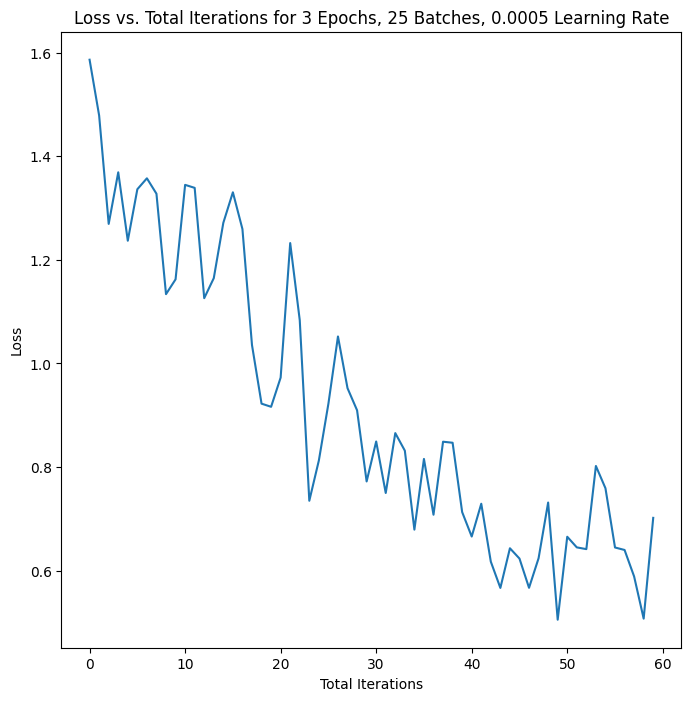

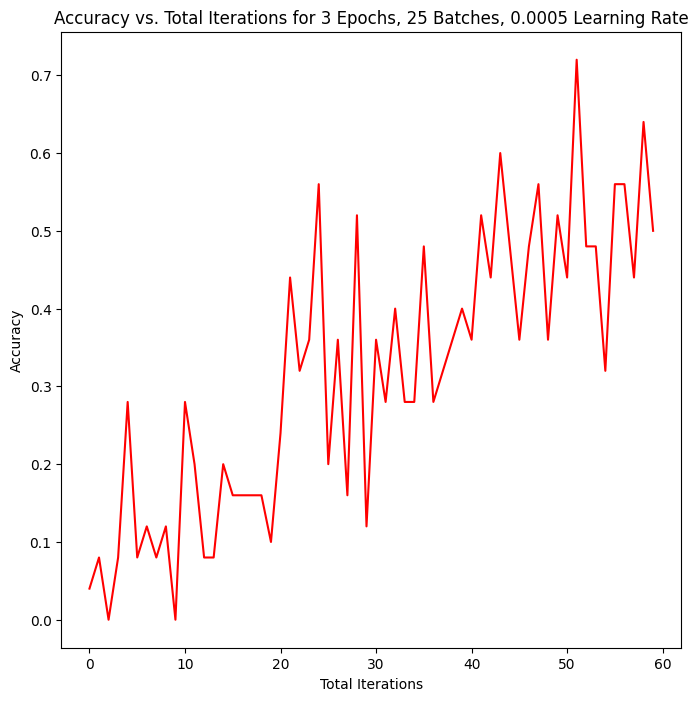

In [47]:
# Model Training - Minibatch
import matplotlib.pyplot as plt
num_epochs = 3
num_iters = len(validset) / batch_size

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)
        
        

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
            break
            
torch.save(net.state_dict(), f"trained{num_epochs}_{batch_size}_{lr}.pth")
            
plt.figure(figsize=(8, 8))
plt.plot(loss_hist)
plt.title(f"Loss vs. Total Iterations for {num_epochs} Epochs, {batch_size} Batches, {lr} Learning Rate")
plt.xlabel("Total Iterations")
plt.ylabel("Loss")
plt.savefig(f"lossPlot{num_epochs}_{batch_size}_{lr}.jpg")
plt.show()
plt.close()

# Plot accuracy
plt.figure(figsize=(8, 8))
plt.plot(acc_hist, color='red')
plt.title(f"Accuracy vs. Total Iterations for {num_epochs} Epochs, {batch_size} Batches, {lr} Learning Rate")
plt.xlabel("Total Iterations")
plt.ylabel("Accuracy")
plt.savefig(f"accPlot{num_epochs}_{batch_size}_{lr}.jpg")
plt.show()
plt.close()

In [34]:
batch_size = 214 # Validation set
validloader = DataLoader(validset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)


In [35]:
net.load_state_dict(torch.load("trained5_25_0.0005.pth")) # importing saved models
net.eval()

Sequential(
  (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Leaky()
  (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Leaky()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=76608, out_features=24, bias=True)
  (8): Leaky()
)

In [36]:
print(len(validset))

214


In [37]:
import matplotlib.pyplot as plt # Calculating validation accuracy and loss for the entire validation set
num_epochs = 1
batch_size = 214
num_iters = len(validset) / batch_size

loss_hist_val = []
acc_hist_val = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(validloader)):
        data_val = data.to(device)
        targets_val = targets.to(device)
        
        spk_rec_val = forward_pass(net, data_val)
        loss_val = loss_fn(spk_rec_val, targets_val)

        # Store loss history for future plotting
        loss_hist_val.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nValid Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec_val, targets_val)
        acc_hist_val.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
                        

Epoch 0, Iteration 0 
Valid Loss: 0.53
Accuracy: 55.14%



In [38]:
batch_size = 25
validloader = DataLoader(validset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

Epoch 0, Iteration 0 
Valid Loss: 0.51
Accuracy: 52.00%

Epoch 0, Iteration 1 
Valid Loss: 0.58
Accuracy: 52.00%

Epoch 0, Iteration 2 
Valid Loss: 0.54
Accuracy: 52.00%

Epoch 0, Iteration 3 
Valid Loss: 0.51
Accuracy: 56.00%

Epoch 0, Iteration 4 
Valid Loss: 0.49
Accuracy: 48.00%

Epoch 0, Iteration 5 
Valid Loss: 0.51
Accuracy: 68.00%

Epoch 0, Iteration 6 
Valid Loss: 0.65
Accuracy: 52.00%

Epoch 0, Iteration 7 
Valid Loss: 0.50
Accuracy: 64.00%

Epoch 0, Iteration 8 
Valid Loss: 0.52
Accuracy: 50.00%



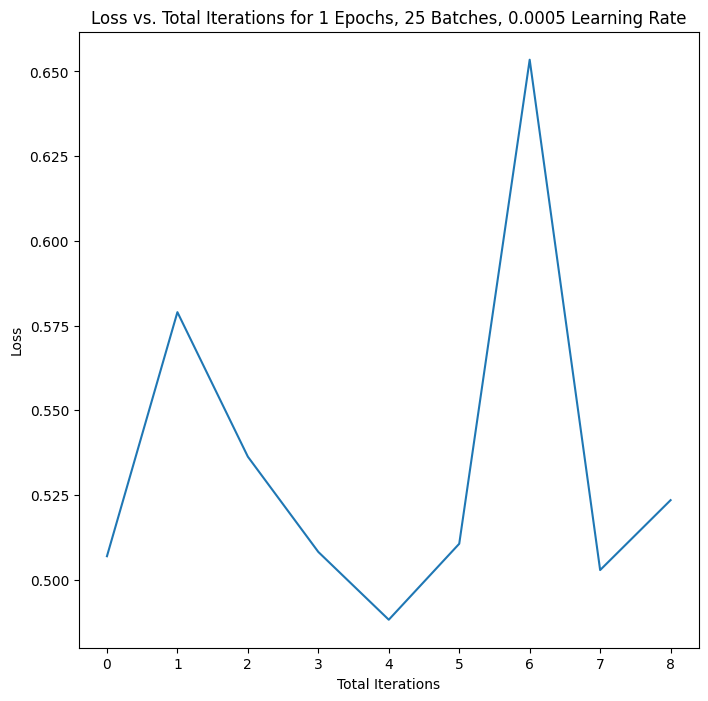

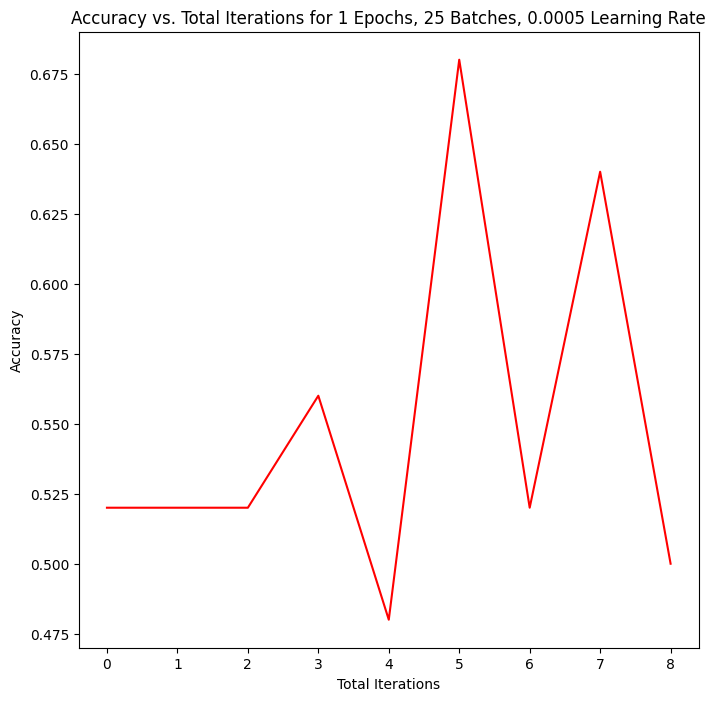

In [39]:
import matplotlib.pyplot as plt # Calculating validation accuracy and loss for different batches of the validation set
num_epochs = 1
num_iters = len(validset) / batch_size

loss_hist_val = []
acc_hist_val = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(validloader)):
        data_val = data.to(device)
        targets_val = targets.to(device)
        
        spk_rec_val = forward_pass(net, data_val)
        loss_val = loss_fn(spk_rec_val, targets_val)

        # Store loss history for future plotting
        loss_hist_val.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nValid Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec_val, targets_val)
        acc_hist_val.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
                        
plt.figure(figsize=(8, 8))
plt.plot(loss_hist_val)
plt.title(f"Loss vs. Total Iterations for {num_epochs} Epochs, {batch_size} Batches, {lr} Learning Rate")
plt.xlabel("Total Iterations")
plt.ylabel("Loss")
# plt.savefig(f"../graphs/loss/lossPlot{num_epochs}_{batch_size}_{lr}.jpg")
plt.show()
plt.close()

# Plot accuracy
plt.figure(figsize=(8, 8))
plt.plot(acc_hist_val, color='red')
plt.title(f"Accuracy vs. Total Iterations for {num_epochs} Epochs, {batch_size} Batches, {lr} Learning Rate")
plt.xlabel("Total Iterations")
plt.ylabel("Accuracy")
# plt.savefig(f"../graphs/acc/accPlot{num_epochs}_{batch_size}_{lr}.jpg")
plt.show()
plt.close()